# Seasonality

Loading data from matlab struct, reformatted in matlab from matlab table and then looking at the seasonality of the WIM data at Ceneri. The years 2011-2019 were looked at and then due to gaps in data only 2014 was used to look at daily/hourly seasonality.

In [18]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=13)

In [4]:
stations = ['Ceneri', 'Denges', 'Gotthard']

Below shows the 2014 seasonality by day. First it is necessary to remove any holidays or sundays. Sundays can easily be removed with the datetime and the holidays are taking from a list of Ticino holidays.

In [26]:
holidays = ['2014-01-01', '2014-01-06', '2014-03-19', '2014-04-21', '2014-05-01', '2014-05-29', '2014-06-09', '2014-06-19', 
            '2014-06-29', '2014-08-01', '2014-08-15', '2014-11-01', '2014-12-07', '2014-12-25', '2014-12-26']

### Truck Weight Seasonality

This section will explore if there is any seasonality with the truck weight/number of trucks within a given time span.

In [5]:
def count_seasonality(station, start_year, end_year, seasonality, pickle):
    if seasonality == 'Daily':
        frequency = 24
        truck_count = 'Weekday'
        seasonal = 'Date_d'
        precision = 'Hour'
        
    elif seasonality == 'Weekly':
        frequency = 7
        truck_count = 'Day of year'
        seasonal = 'Date_d'
        precision = 'Date_d'
        months = [3, 4, 5] #Taking months March, April, May
    
    #Get the general truck data for normalization
    df_truck = pd.read_pickle('{}Data/{}_{}_datetime.pkl'.format(station, start_year, end_year))
    df_truck['Weekday'] = df_truck.Date.dt.weekday
    df_truck['Hour'] = df_truck.Date.dt.hour
    df_truck['Date_d'] = df_truck.Date.dt.date
    df_truck['Day of year'] = df_truck.Date.dt.dayofyear
    df_truck['Year'] = df_truck.Date.dt.year

    if seasonality == 'Weekly':
        df_truck_hour = df_truck.groupby([truck_count]).Date.count().reset_index().rename(columns={'Date':'count'})
    
    elif seasonality == 'Daily':
        #if minute:
         #   df_platoon['Minute'] = df_platoon.Date.dt.minute
         #   df_platoon_hour = df_platoon.groupby([truck_count, precision, 'Minute']).Date.count().reset_index().rename(columns={'Start':'count'}) #Total count by weekday/hour
        #else:
        df_truck_hour = df_truck.groupby([truck_count,precision]).Date.count().reset_index().rename(columns={'Date':'count'}) #Total count by weekday/hour

    df_truck_date = df_truck.groupby([truck_count])[seasonal].nunique().reset_index().rename(columns={seasonal:'seasonal_count'}) #Total days by weekday represented
    df_truck_grouped = df_truck_date.merge(df_truck_hour, on=truck_count)
    df_truck_grouped = df_truck_grouped.set_index(truck_count)
    
    #Normalizing
    df_truck_grouped['norm_count'] = df_truck_grouped['count']/df_truck_grouped['seasonal_count']
    
    #Renaming days of the week
    if seasonality == 'Daily':
        df_truck_grouped = df_truck_grouped.rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: 'Thursday', 4: 'Friday',
                                                     5: 'Saturday', 6:'Sunday'})
    
    if pickle:
        df_truck_grouped.to_pickle('{}Data/platoon_{}_seasonality_{}_{}.pkl'.format(station, seasonality, start_year, end_year))
    else:
        #Plotting
        #df_platoon_grouped.norm_count.plot(title="{} Normalized Natural Truck Platoon with at least 2, count by hour".format(station))
        result = seasonal_decompose(df_truck_grouped.norm_count, model='additive', freq=frequency)
        fig = result.plot()

        fig.suptitle('{} {} Count Decomposition'.format(station, seasonality), y=1.03)

        fig.savefig('Figures/{}/{}_count_season.png'.format(station, seasonality), bbox_inches='tight')

        plt.show()

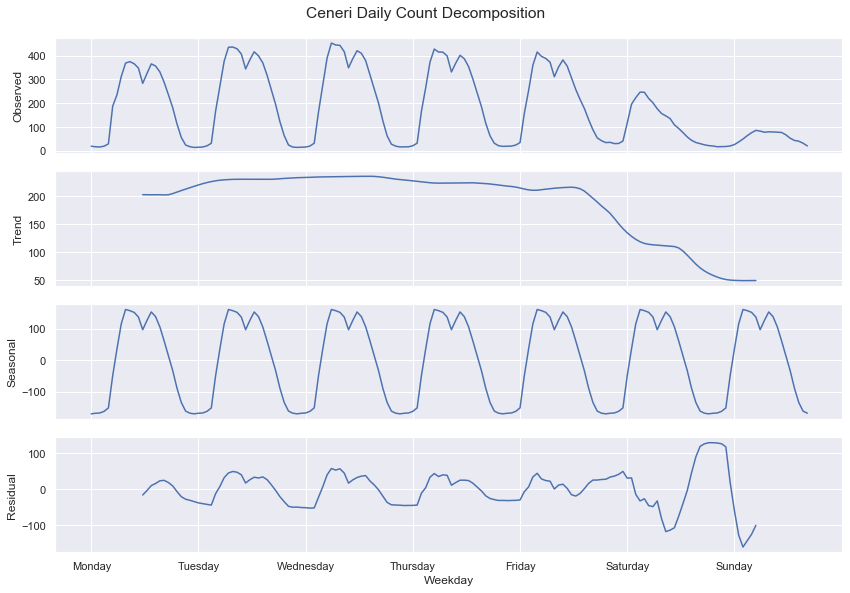

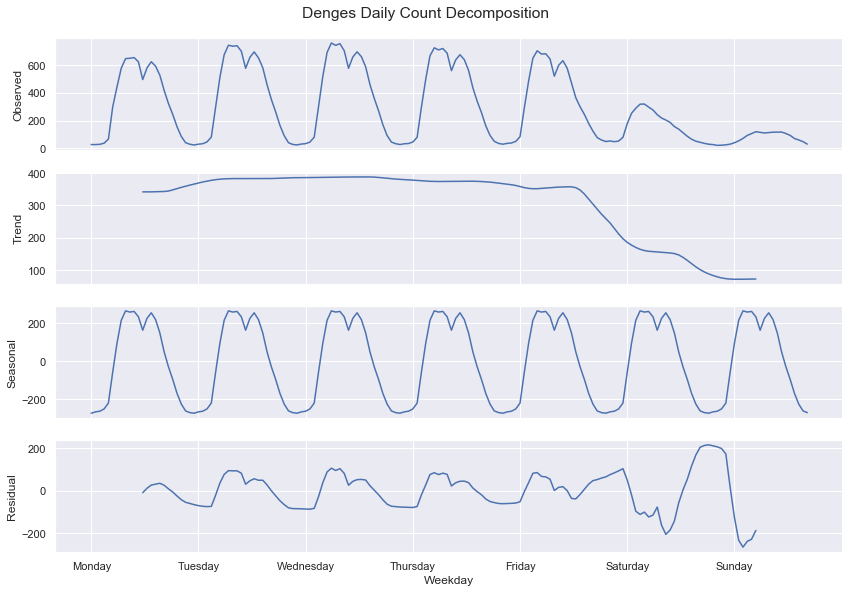

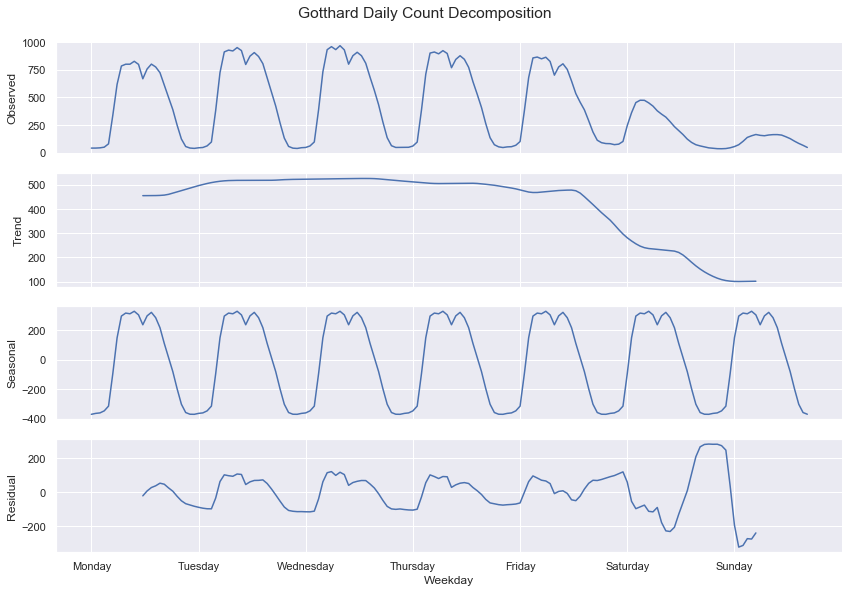

In [22]:
for station in stations:
    count_seasonality(station, 'Daily', False)

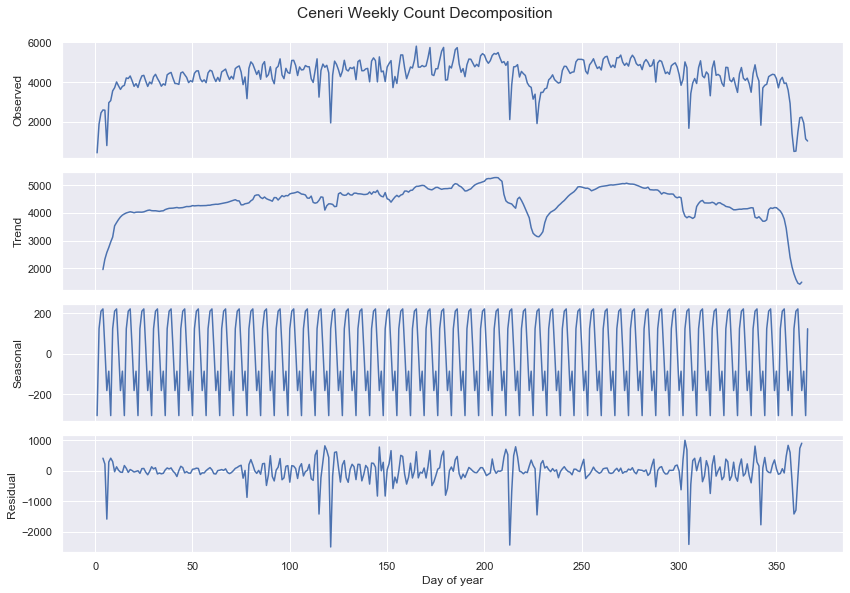

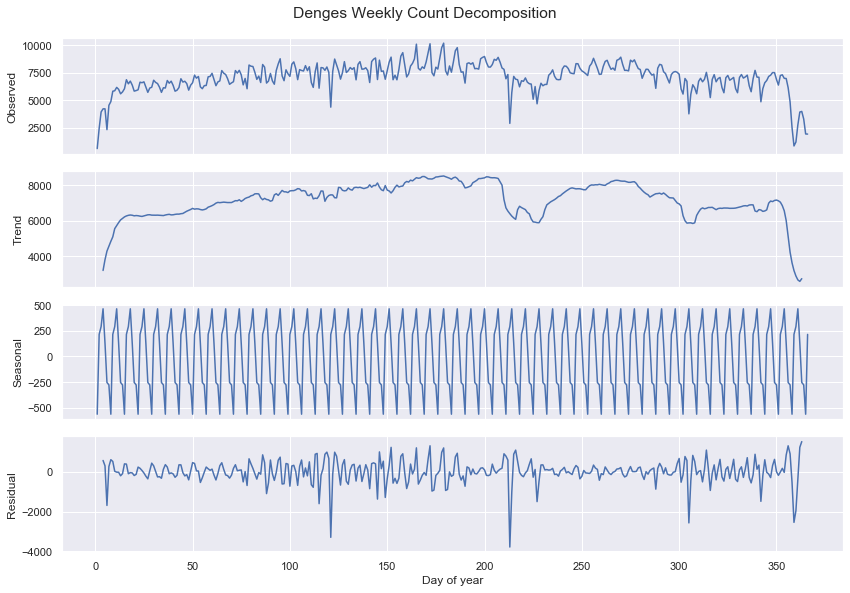

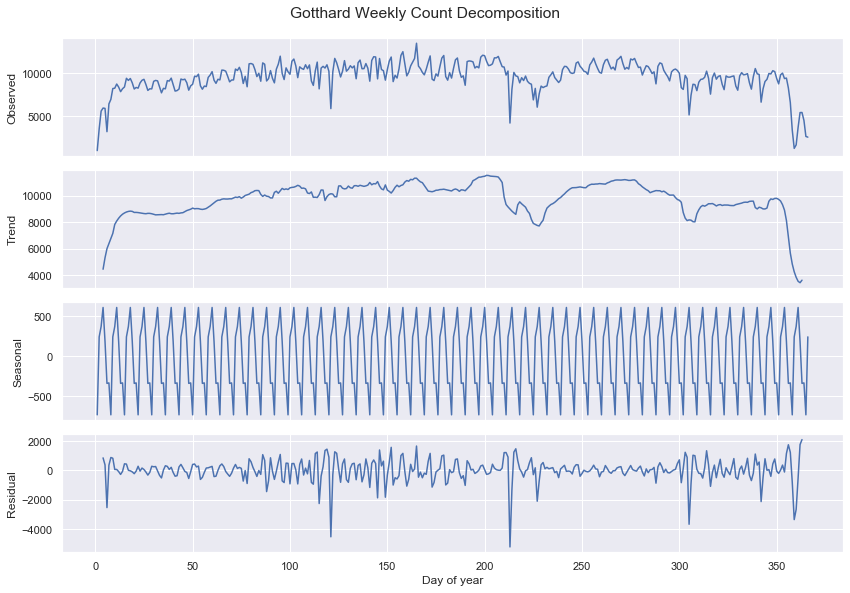

In [25]:
for station in stations:
    count_seasonality(station, 'Weekly', False)

In [6]:
def weight_seasonality(station, start_year, end_year, seasonality):

    if seasonality == 'Daily':
        frequency = 24
        truck_count = 'Weekday'
        seasonal = 'Date_d'
        precision = 'Hour'
        model = 'additive'
        
    elif seasonality == 'Weekly':
        frequency = 7
        truck_count = 'DoY'
        seasonal = 'Date_d'
        precision = 'Date_d'
        months = [3, 4, 5] #Taking months March, April, May
        model = 'additive'
    
    #Get the general truck data
    df_truck = pd.read_pickle('{}Data/{}_{}_datetime.pkl'.format(station, start_year, end_year))
    df_truck['Weekday'] = df_truck.Date.dt.weekday
    
    #Remove saturday and sunday
    #df_truck = df_truck[~df_truck.Weekday.isin([5, 6])]
    
    df_truck['Hour'] = df_truck.Date.dt.hour
    df_truck['Date_d'] = df_truck.Date.dt.date
    df_truck['GW_TOT'] = df_truck['GW_TOT']/1000
    
    if seasonality == 'Daily':
        df_truck_hour = df_truck.groupby([truck_count,precision]).GW_TOT.mean()
        
    elif seasonality == 'Weekly':
        df_truck['Day of year'] = df_truck.Date.dt.dayofyear
        df_truck_hour = df_truck.groupby('Day of year').GW_TOT.mean()
    
    #Renaming days of the week
    if seasonality == 'Daily':
        df_truck_hour = df_truck_hour.reset_index(1)
        df_truck_hour = df_truck_hour.drop(columns='Hour')
        df_truck_hour = df_truck_hour.rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: 'Thursday', 4: 'Friday',
                                                     5: 'Saturday', 6:'Sunday'})        
        
    #Plotting
    #df_truck_hour.plot(title="{} Normalized Natural Truck Platoon with at least 2, count by hour".format(station))
    result = seasonal_decompose(df_truck_hour, model=model, freq=frequency)
    fig = result.plot()
    fig.suptitle('{} {} Weight Decomposition'.format(station, seasonality), y=1.03)
        
    fig.savefig('Figures/{}/{}_weight_season.png'.format(station, seasonality), bbox_inches='tight')
    
    plt.show()    

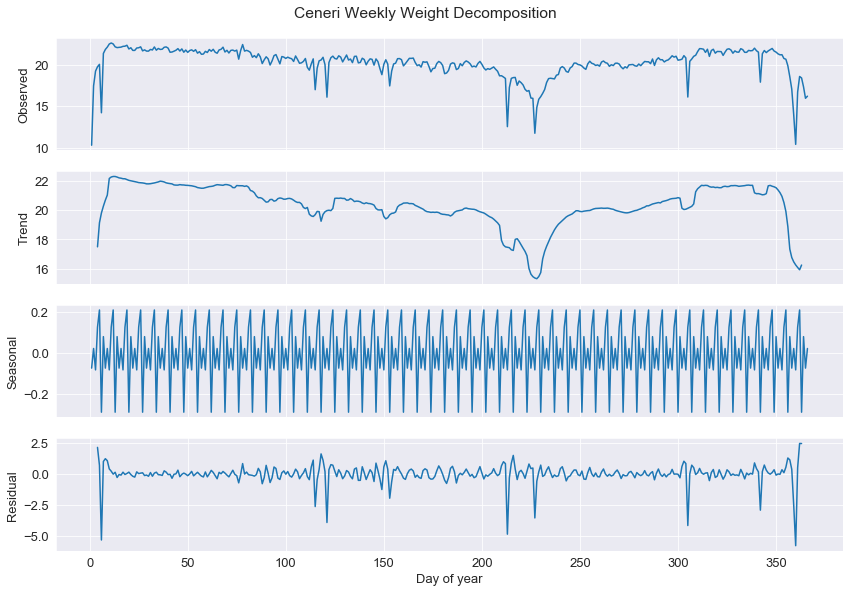

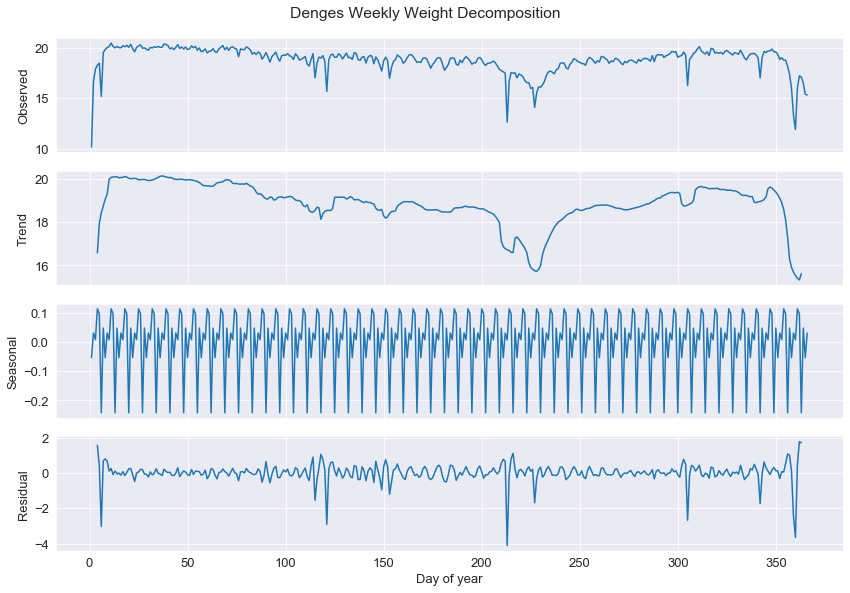

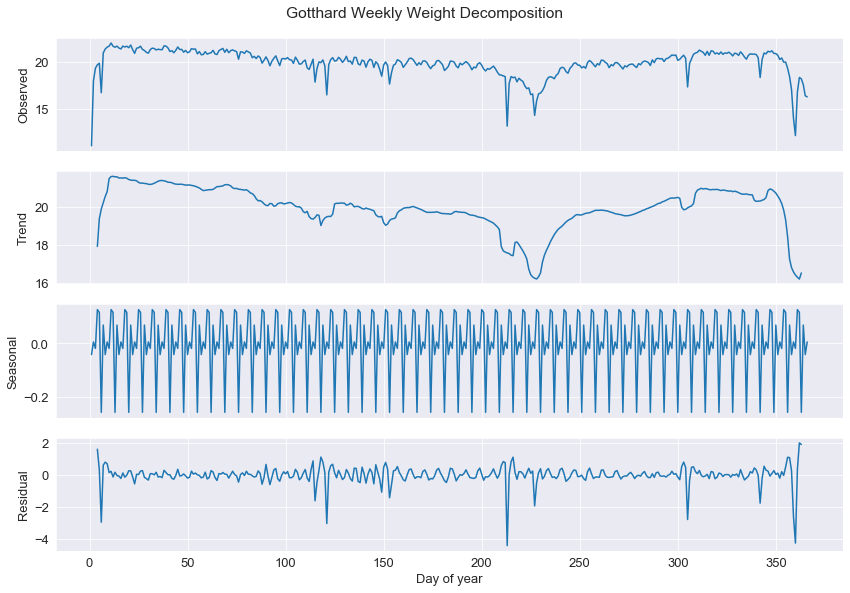

In [52]:
for station in stations:
    #weight_seasonality(station, 'Daily')
    weight_seasonality(station, 'Weekly')

## Platoon Seasonality

This section will take the platoons found in the PlatoonFinding folder and plot the beginning time of the platoon, grouping by hour and day of the week.

In [7]:
def platoon_seasonality(station, start_year, end_year, headway, seasonality, minute, pickle):
    
    if seasonality == 'Daily':
        frequency = 24
        truck_count = 'Weekday'
        seasonal = 'Date_d'
        precision = 'Hour'
        
    elif seasonality == 'Weekly':
        frequency = 7
        truck_count = 'Day of year'
        seasonal = 'Date_d'
        precision = 'Date_d'
        months = [3, 4, 5] #Taking months March, April, May
    
    #Get the platoon data
    df_platoon = pd.read_pickle('{}Data/{}_{}_platoon_h{}.pkl'.format(station, start_year, end_year, headway))
    #df_platoon = df_platoon[df_platoon.Length > 1] #Only keep platoons that are at least of length 2
    df_platoon['Weekday'] = df_platoon.Start.dt.weekday
    df_platoon['Hour'] = df_platoon.Start.dt.hour
    df_platoon['Date_d'] = df_platoon.Start.dt.date
    df_platoon['Day of year'] = df_platoon.Start.dt.dayofyear
    df_platoon['Year'] = df_platoon.Start.dt.year

    
    #Get the general truck data for normalization
    df_truck = pd.read_pickle('{}Data/{}_{}_datetime.pkl'.format(station, start_year, end_year))
    df_truck['Weekday'] = df_truck.Date.dt.weekday
    df_truck['Hour'] = df_truck.Date.dt.hour
    df_truck['Date_d'] = df_truck.Date.dt.date
    df_truck['Day of year'] = df_truck.Date.dt.dayofyear
    df_truck['Year'] = df_truck.Date.dt.year

    if seasonality == 'Weekly':
        df_platoon_hour = df_platoon.groupby([truck_count]).Start.count().reset_index().rename(columns={'Start':'count'})
    
    elif seasonality == 'Daily':
        if minute:
            df_platoon['Minute'] = df_platoon.Start.dt.minute
            df_platoon_hour = df_platoon.groupby([truck_count, precision, 'Minute']).Start.count().reset_index().rename(columns={'Start':'count'}) #Total count by weekday/hour
        else:
            df_platoon_hour = df_platoon.groupby([truck_count,precision]).Start.count().reset_index().rename(columns={'Start':'count'}) #Total count by weekday/hour

    df_truck_date = df_truck.groupby([truck_count])[seasonal].nunique().reset_index().rename(columns={seasonal:'seasonal_count'}) #Total days by weekday represented
    df_platoon_grouped = df_truck_date.merge(df_platoon_hour, on=truck_count)
    df_platoon_grouped = df_platoon_grouped.set_index(truck_count)
    
    #Normalizing
    df_platoon_grouped['norm_count'] = df_platoon_grouped['count']/df_platoon_grouped['seasonal_count']
    
    #Renaming days of the week
    if seasonality == 'Daily':
        df_platoon_grouped = df_platoon_grouped.rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: 'Thursday', 4: 'Friday',
                                                     5: 'Saturday', 6:'Sunday'})
    
    if pickle:
        df_platoon_grouped.to_pickle('{}Data/platoon_{}_seasonality_{}_{}_h{}.pkl'.format(station, seasonality, start_year, end_year, headway))
    else:
        #Plotting
        #df_platoon_grouped.norm_count.plot(title="{} Normalized Natural Truck Platoon with at least 2, count by hour".format(station))
        result = seasonal_decompose(df_platoon_grouped.norm_count, model='additive', freq=frequency)
        fig = result.plot()

        fig.suptitle('{} {} Platoon Decomposition'.format(station, seasonality), y=1.03)

        fig.savefig('Figures/{}/{}_platoon_season.png'.format(station, seasonality), bbox_inches='tight')

        plt.show()

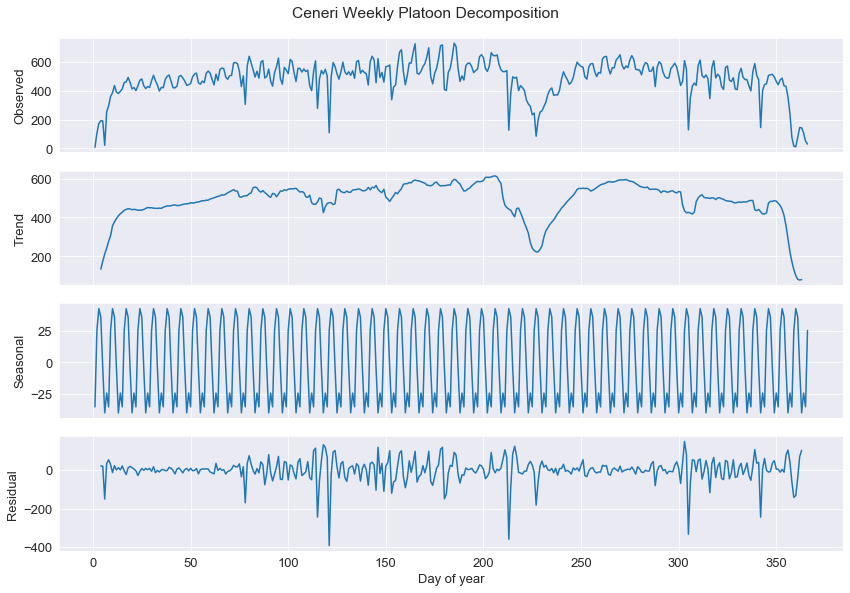

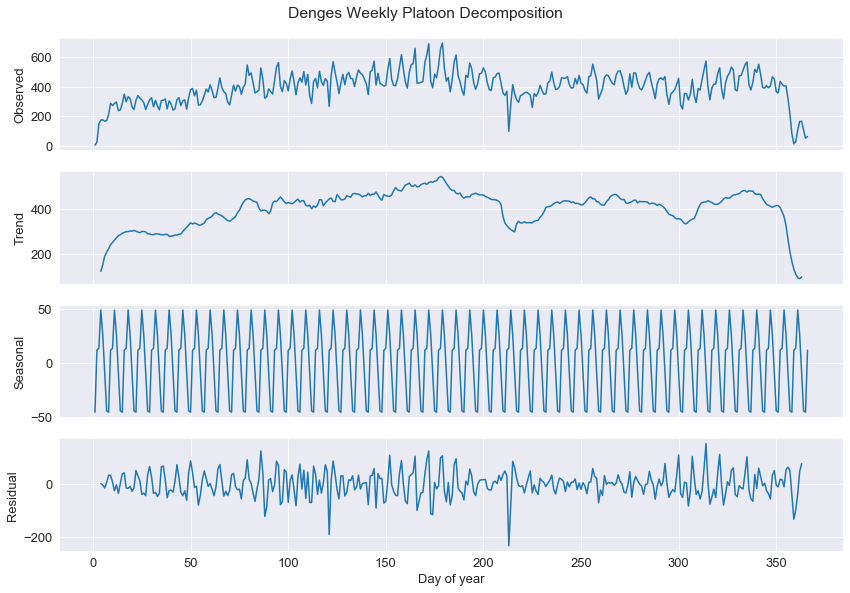

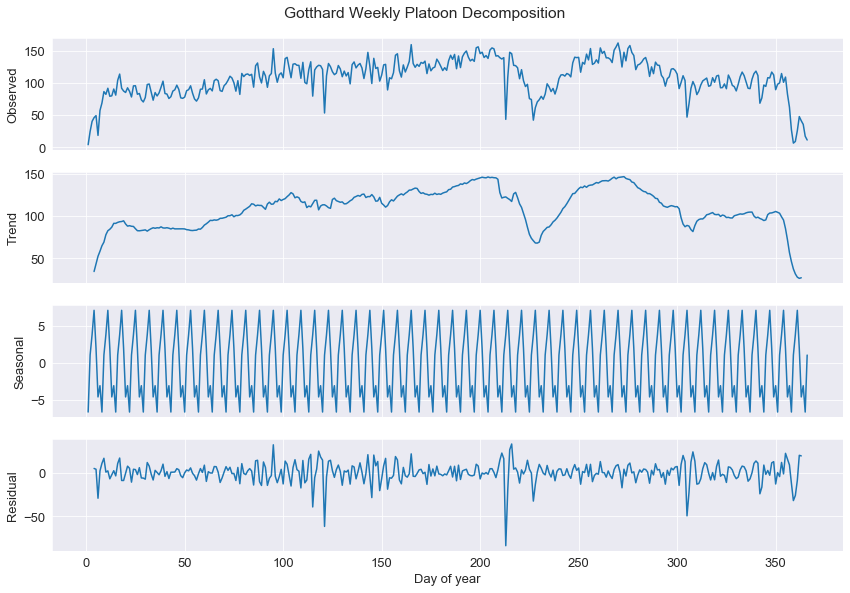

In [56]:
for station in stations:
    platoon_seasonality(station, 'Weekly')

In [9]:
for station in stations:
    platoon_seasonality(station, 'Daily', True, True)

### Correlation

This section aims to investigate the correlation between features to see which features are correlated together, particularly with time.

In [94]:
df = pd.read_csv('{}Data/2011_2018_datetime.csv'.format(Station), index_col=0, parse_dates=['Date']) 

C:\Users\Isabelle\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [95]:
df.head()

FS  GW_TOT  CLASS  ZST  LENTH  CS                Date
0   4    3500      0  408    674   5 2011-01-01 00:54:14
1   4    5270      0  408    839   8 2011-01-01 00:54:48
2   4   19280     12  408   1429  10 2011-01-01 02:43:02
3   4    4400      0  408    742   5 2011-01-01 02:54:33
4   4    4090      0  408    819   8 2011-01-01 03:12:30

In [97]:
df['weekday'] = df.Date.dt.weekday

In [99]:
df['hour'] = df.Date.dt.hour

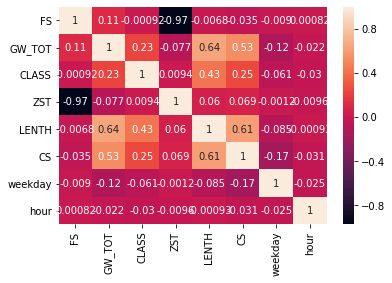

In [100]:
import matplotlib.pyplot as plt
import seaborn as sn

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()